In [1]:
import pandas as pd
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

labelencoder = LabelEncoder()

import xgboost as xgb
import random

import numpy as np
from sklearn.cluster import KMeans
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


* Match Dataset: https://oracleselixir.com/about
* Stats Dataset: https://www.kaggle.com/carralas/league-of-legends-champion-stats-922

## Champion Stats 

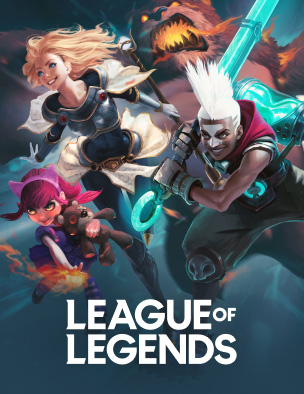

### Champion의 stats를 토대로 Clustering

리그오브레전드(LoL)의 각 챔피언들은 고유의 능력치들이 있다. 마법사는 주문력(AP)가 높아 스킬들의 데미지가 크다던가 저격수들은 원거리에서 공격을 하기에 공격력은 높지만 체력은 낮다. 따라서 각 챔피언들의 레벨 1 때의 기본 수치들을 살펴보면 챔피언이 어떤 역할군으로 활용될지 판단이 되는 경우가 있다. 하지만 이를 빗나가는 경우도 있는데 이는 성장에 따라, 챔피언의 고유 능력에 따라 레벨 1때는 약하지만 나중에는 강해지는 등 다양한 요소들이 있기 때문이다. 따라서 챔피언의 수치(Stats)로 챔피언들을 Clustering하는 것은 불가능하다.

하지만 이를 요약된 정보로는 가능해보였다. 예를 들어, 체력 / 회복속도 / 주문력 계수 등과 같이 지나치게 상세한 수치들은 Clustering에 도움이 안되지만, 단순히 공격, 방어, 마법 등과 같이 추상적으로 표현해놓은 수치들은 오히려 Clustering을 하기 더 용이했다. 또한 LoL은 게임의 다양성을 위하여 하나의 챔피언을 하나의 역할군(탑, 미드 etc)에 고정하지 않는데 이는 Clustering이 필요하게 하는 이유이면서 어렵게 하는 이유 중 하나이지만, 해당 챔피언의 보편적인 직업(마법사, 전사 etc)을 지정하는 데이터셋이 있기에 이를 사용하였다.

In [20]:
# Champion Stats Dataset
champs = pd.read_csv("champion_stats.csv", index_col=0)

champs['tags'] = champs['tags'].apply(lambda x: literal_eval(str(x)))

mlb = MultiLabelBinarizer()

champ_class = pd.DataFrame(mlb.fit_transform(champs['tags']),columns=mlb.classes_, index=champs.index)

champ_all = pd.concat([champs, champ_class], axis=1)
champ_all = champ_all.drop(['tags'], axis = 1)

In [21]:
champ_all.head()

,id,key,attack,defense,magic,difficulty,hp,hpperlevel,mp,mpperlevel,...,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed,Assassin,Fighter,Mage,Marksman,Support,Tank
0,Aatrox,266,8,4,3,4,580.00,90,0.0,0.0,...,60.00,5.00,2.500,0.651,0,1,0,0,0,1
1,Ahri,103,3,4,8,5,526.00,92,418.0,25.0,...,53.04,3.00,2.000,0.668,1,0,1,0,0,0
2,Akali,84,5,3,8,7,575.00,95,200.0,0.0,...,62.40,3.30,3.200,0.625,1,0,0,0,0,0
3,Alistar,12,6,9,5,7,600.00,106,350.0,40.0,...,62.00,3.75,2.125,0.625,0,0,0,0,1,1
4,Amumu,32,2,6,8,3,613.12,84,287.2,40.0,...,53.38,3.80,2.180,0.736,0,0,1,0,0,1


챔피언의 Stats 정보를 통해 클러스터링 하기 위하여 다음과 같은 절차를 따랐다.

* 챔피언의 Tag에 대하여 MultiLabelBinarizer를 사용하여 표현하였다. 이를 통해 각 챔피언의 Tag가 두개 이상인 경우, One-Hot Encoding이 아니라 해당하는 모든 경우에 1을 입력해두었다. 
* ['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']에 대하여 Clustering을 진행했으며, Clustering 자체가 Unsupervised이므로 군집에 대한 평가는 직접 진행했다. 
* 군집은 5개로 설정하였고, 

### K-means++

In [29]:
champs_selected = champ_all[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0) 

y_km = km.fit_predict(champs_selected)

champs_copy = champ_all.copy()
champs_copy['key'] = y_km

champs_selected['key'] = y_km

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
# Agglomerative clustering with K=3
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
labels = agg.fit_predict(champs_selected)
print('Cluster labels: %s' % labels)

champs_copy['key'] = labels
champs_selected['key'] = labels

Cluster labels: [4 0 3 2 0 0 0 1 1 0 3 3 2 0 2 1 4 0 2 3 4 3 1 2 3 3 3 3 0 1 3 2 4 4 3 2 4
 4 0 4 3 0 0 4 3 1 1 1 4 1 0 0 0 0 3 4 3 1 1 1 1 0 4 2 0 0 4 3 0 2 0 2 1 1
 4 2 0 3 3 2 0 3 4 2 4 0 2 1 4 1 0 1 0 2 4 4 4 4 0 0 2 3 4 3 2 4 2 2 1 4 3
 0 0 0 0 2 0 1 2 3 2 1 4 4 3 1 4 4 1 1 0 0 4 0 0 4 4 4 0 4 1 1 4 3 2 1 0 0
 0 0 4 0]


/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
from sklearn.decomposition import PCA
import plotly.express as px

X = champs_selected[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=champs_selected['key'])
fig.show()

X = champs_selected[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=champs_selected['key'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

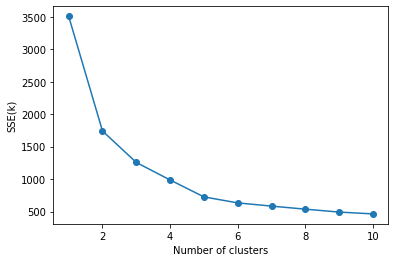

In [32]:
# Elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=10,
                max_iter=300, random_state=0)  # n_init=10: K-means++ with K=10을 의미
    km.fit(champs_selected)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE(k)')
plt.show()

In [33]:
champs_copy['key'] = ['category_'+str(i) for i in champs_copy['key'] ]

### Category

* category_0: 미드 포지션을 담당하는 챔피언들이 많다. Magic 수치가 높으며, 직업군으로 Mage / Support를 많이 담당하고 있다.
* category_1: 원거리 딜러 포지션을 담당하는 챔피언들이 많다. Attack 수치가 높으며 방어가 낮아 간혹 Khazix, MasterYi 같은 챔프도 존재한다.
* category_2: 탱커 포지션을 담당하는 챔피언들이 많다. 다른 카테고리는 다양한 직업군이 섞여 있는 경우가 있는데 이는 단일하다.
* category_3: 전사 포지션을 담당하는 챔피언들이 많다. 흔히 말하는 공격과 방어를 동시에 하는 '딜탱'들이 속한다.
* category_4: 암살자 포지션을 담당하는 챔피언들이 많다. 한번에 공격을 퍼붓는 '누커'나 속칭 '짤짤이'를 넣는 챔프들이 속한다.

In [34]:
champ_dict = {}
for index in range(len(champs_copy)):
    champ_name = champs_copy['id'][index]
    champ_name = champ_name.lower()
    champ_name = champ_name.replace("'", "")
    champ_name = champ_name.replace(" ", "")
    champ_type = champs_copy['key'][index]
    champ_dict[champ_name] = champ_type
    
champ_dict

{'aatrox': 'category_4',
 'ahri': 'category_0',
 'akali': 'category_3',
 'alistar': 'category_2',
 'amumu': 'category_0',
 'anivia': 'category_0',
 'annie': 'category_0',
 'aphelios': 'category_1',
 'ashe': 'category_1',
 'aurelionsol': 'category_0',
 'azir': 'category_3',
 'bard': 'category_3',
 'blitzcrank': 'category_2',
 'brand': 'category_0',
 'braum': 'category_2',
 'caitlyn': 'category_1',
 'camille': 'category_4',
 'cassiopeia': 'category_0',
 'chogath': 'category_2',
 'corki': 'category_3',
 'darius': 'category_4',
 'diana': 'category_3',
 'draven': 'category_1',
 'drmundo': 'category_2',
 'ekko': 'category_3',
 'elise': 'category_3',
 'evelynn': 'category_3',
 'ezreal': 'category_3',
 'fiddlesticks': 'category_0',
 'fiora': 'category_1',
 'fizz': 'category_3',
 'galio': 'category_2',
 'gangplank': 'category_4',
 'garen': 'category_4',
 'gnar': 'category_3',
 'gragas': 'category_2',
 'graves': 'category_4',
 'hecarim': 'category_4',
 'heimerdinger': 'category_0',
 'illaoi': 'c

In [35]:
unnecess_col = ['playoffs', 'gameid', 'datacompleteness', 'url', 'year', 'split', 'playerid',
 'date', 'patch', 'position', 'player', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 
 'firstbloodkill', 'ckpm',  'firstbloodassist', 'firstbloodvictim', 'golddiffat10', 'csdiffat10','xpdiffat10',
 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'dragons (type unknown)', 'earned gpm', 'goldspent', 
 'team kpm', 'gspd', 'earnedgold', 'totalgold', 'goldat10', 'goldat15', 
 'opp_elders', 'opp_heralds', 'opp_barons', 'opp_towers','opp_inhibitors', 'damageshare', 'earnedgoldshare', 
 'total cs', 'opp_goldat10','opp_xpat10','opp_csat10', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15']

kill 차이를 통해 압도적인 승리와 팽팽한 승리를 비교

### 2020년도 모든 대회 데이터들에 대하여 분석

전처리 절차
* league 데이터에 대하여, 불필요한 Column 삭제
* NLC League는 북유럽 리그인데 이들 데이터에서 팀명 누락이 자주 발생하여 삭제
* 각 팀의 선택 챔피언과 금지 챔피언을 한 Column에 모아 MultiLabelBinarizer 진행
* 변수 타입별 조정


In [36]:
league = pd.read_csv("2020_LOL.csv")
league = league[league.columns[~league.columns.isin(unnecess_col)]].reset_index(drop=True)

ban_list = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
for ban in ban_list:
    league[ban] = league[ban].str.lower()
    league[ban] = league[ban].str.replace("'", "")
    league[ban] = league[ban].str.replace(" ", "")
    league[ban] = league[ban].str.replace(".", "")
    league[ban] = league[ban].str.replace("&willump", "")
    league[ban] = league[ban].str.replace("wukong", "monkeyking")
    
league['side'] = [1 if i == 'Blue' else 0 for i in league['side'] ]
league['firstdragon'] = league['firstdragon'].astype('bool')
league['firstherald'] = league['firstherald'].astype('bool')
league['firstbaron'] = league['firstbaron'].astype('bool')
league['firsttower'] = league['firsttower'].astype('bool')
league['firstmidtower'] = league['firstmidtower'].astype('bool')
league['firsttothreetowers'] = league['firsttothreetowers'].astype('bool')

league = league[league['league'] != 'NLC'].reset_index(drop=True)

# 팀 선택 Champion 팀 row에 모으기

for start_index in range(0, len(league), 12):
    if (league['team'][start_index] != league['team'][start_index+1]) or (league['champion'][start_index] == league['champion'][start_index+1]): 
        continue
    else:
        try:
            team_1 = list(league.loc[start_index:start_index+4, 'champion'])
            team_2 = list(league.loc[start_index+5:start_index+9, 'champion'])

            team_1 = [champ_dict[key] for key in team_1]
            team_2 = [champ_dict[key] for key in team_2]

            league.at[start_index+10, 'champion'] = team_1
            league.at[start_index+11, 'champion'] = team_2
        except Exception as e:
            print(start_index)
            print(e)
            
league['result'] = labelencoder.fit_transform(league['result'])
league = league.dropna(axis='rows').reset_index(drop=True)

out_index = []
index = 0
while index < len(league):
    if league.iloc[index]['gamelength'] == league.iloc[index+1]['gamelength']:
        index += 2
    else:
        out_index.append(index)
        index += 1
        
league = league[~league.index.isin(out_index)].reset_index(drop=True)

In [44]:
kill_diff = [np.abs(league['kills'][i] - league['kills'][j]) for i, j in zip(range(0,len(league),2), range(1,len(league),2))]
kill_diff = [i for i in kill_diff for j in range(2)]

In [45]:
from collections import Counter

league['category_0'] = 0
league['category_1'] = 0
league['category_2'] = 0
league['category_3'] = 0
league['category_4'] = 0

for index, data in enumerate(league['champion']):
    data = Counter(data)
    keys = data.keys()
    for key in keys:
        league[key][index] = data[key]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
ban1 = league['ban1']
ban2 = league['ban2']
ban3 = league['ban3']
ban4 = league['ban4']
ban5 = league['ban5']

ban1 = [champ_dict[i] for i in ban1]
ban2 = [champ_dict[i] for i in ban2]
ban3 = [champ_dict[i] for i in ban3]
ban4 = [champ_dict[i] for i in ban4]
ban5 = [champ_dict[i] for i in ban5]

In [47]:
ban_list = league[['ban1', 'ban2', 'ban3', 'ban4', 'ban5']].values

league['bans'] = [bans for bans in ban_list]

for index, bans in enumerate(league['bans']):
    league['bans'][index] = ['ban_'+champ_dict[i] for i in bans]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
league['ban_category_0'] = 0
league['ban_category_1'] = 0
league['ban_category_2'] = 0
league['ban_category_3'] = 0
league['ban_category_4'] = 0

for index, data in enumerate(league['bans']):
    data = Counter(data)
    keys = data.keys()
    for key in keys:
        league[key][index] = data[key]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
league = league.drop(['league', 'game', 'team', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'bans', 'champion', 'gamelength', 'kills' ], axis=1) 

In [50]:
league['kill_diff'] = kill_diff

In [51]:
league

,side,result,firstblood,firstdragon,dragons,infernals,mountains,clouds,oceans,elders,...,category_1,category_2,category_3,category_4,ban_category_0,ban_category_1,ban_category_2,ban_category_3,ban_category_4,kill_diff
0,1,1,0.0,False,2.0,0.0,2.0,0.0,0.0,0.0,...,1,1,1,0,1,1,0,1,2,6
1,0,0,1.0,True,3.0,1.0,1.0,1.0,0.0,0.0,...,0,2,0,2,0,0,0,1,4,6
2,1,0,0.0,False,1.0,0.0,0.0,0.0,1.0,0.0,...,2,1,0,1,3,0,2,0,0,16
3,0,1,1.0,True,4.0,0.0,1.0,1.0,2.0,0.0,...,1,1,1,1,0,0,0,2,3,16
4,1,1,0.0,True,4.0,0.0,2.0,1.0,1.0,0.0,...,0,1,0,3,2,0,1,0,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,0,0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,2,0,0,3,16
8680,1,0,0.0,False,1.0,0.0,0.0,1.0,0.0,0.0,...,1,1,2,0,1,0,1,0,3,7
8681,0,1,1.0,True,4.0,1.0,0.0,2.0,1.0,0.0,...,2,1,0,1,0,0,1,0,4,7
8682,1,0,1.0,True,2.0,1.0,1.0,0.0,0.0,0.0,...,1,1,1,1,0,0,2,1,2,20


In [52]:
victory_league = league[league['result'] == 1].reset_index(drop=True)
failure_league = league[league['result'] == 0].reset_index(drop=True)

In [53]:
failure_league

,side,result,firstblood,firstdragon,dragons,infernals,mountains,clouds,oceans,elders,...,category_1,category_2,category_3,category_4,ban_category_0,ban_category_1,ban_category_2,ban_category_3,ban_category_4,kill_diff
0,0,0,1.0,True,3.0,1.0,1.0,1.0,0.0,0.0,...,0,2,0,2,0,0,0,1,4,6
1,1,0,0.0,False,1.0,0.0,0.0,0.0,1.0,0.0,...,2,1,0,1,3,0,2,0,0,16
2,0,0,1.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2,1,1,1,0,0,3,1,17
3,1,0,0.0,True,2.0,0.0,1.0,0.0,1.0,0.0,...,1,1,1,1,3,1,0,0,1,13
4,1,0,0.0,False,1.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,2,2,0,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,0,0,1.0,False,1.0,0.0,0.0,1.0,0.0,0.0,...,2,0,1,2,0,0,1,1,3,6
4338,0,0,0.0,False,1.0,0.0,0.0,1.0,0.0,0.0,...,2,1,1,1,0,0,1,0,4,9
4339,0,0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,0,2,0,0,3,16
4340,1,0,0.0,False,1.0,0.0,0.0,1.0,0.0,0.0,...,1,1,2,0,1,0,1,0,3,7


In [54]:
X = victory_league.drop(['kill_diff'], axis = 1)
y = victory_league['kill_diff']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

regressor = xgb.XGBRegressor()

win_fitted = regressor.fit(x_train, y_train)
pred = win_fitted.predict(x_test)

mean_squared_error(pred, y_test)

17.527139318061398

In [55]:
X = failure_league.drop(['kill_diff'], axis = 1)
y = failure_league['kill_diff']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

regressor = xgb.XGBRegressor()

fail_fitted = regressor.fit(x_train, y_train)
pred = fail_fitted.predict(x_test)

mean_squared_error(pred, y_test)

19.76761813745527

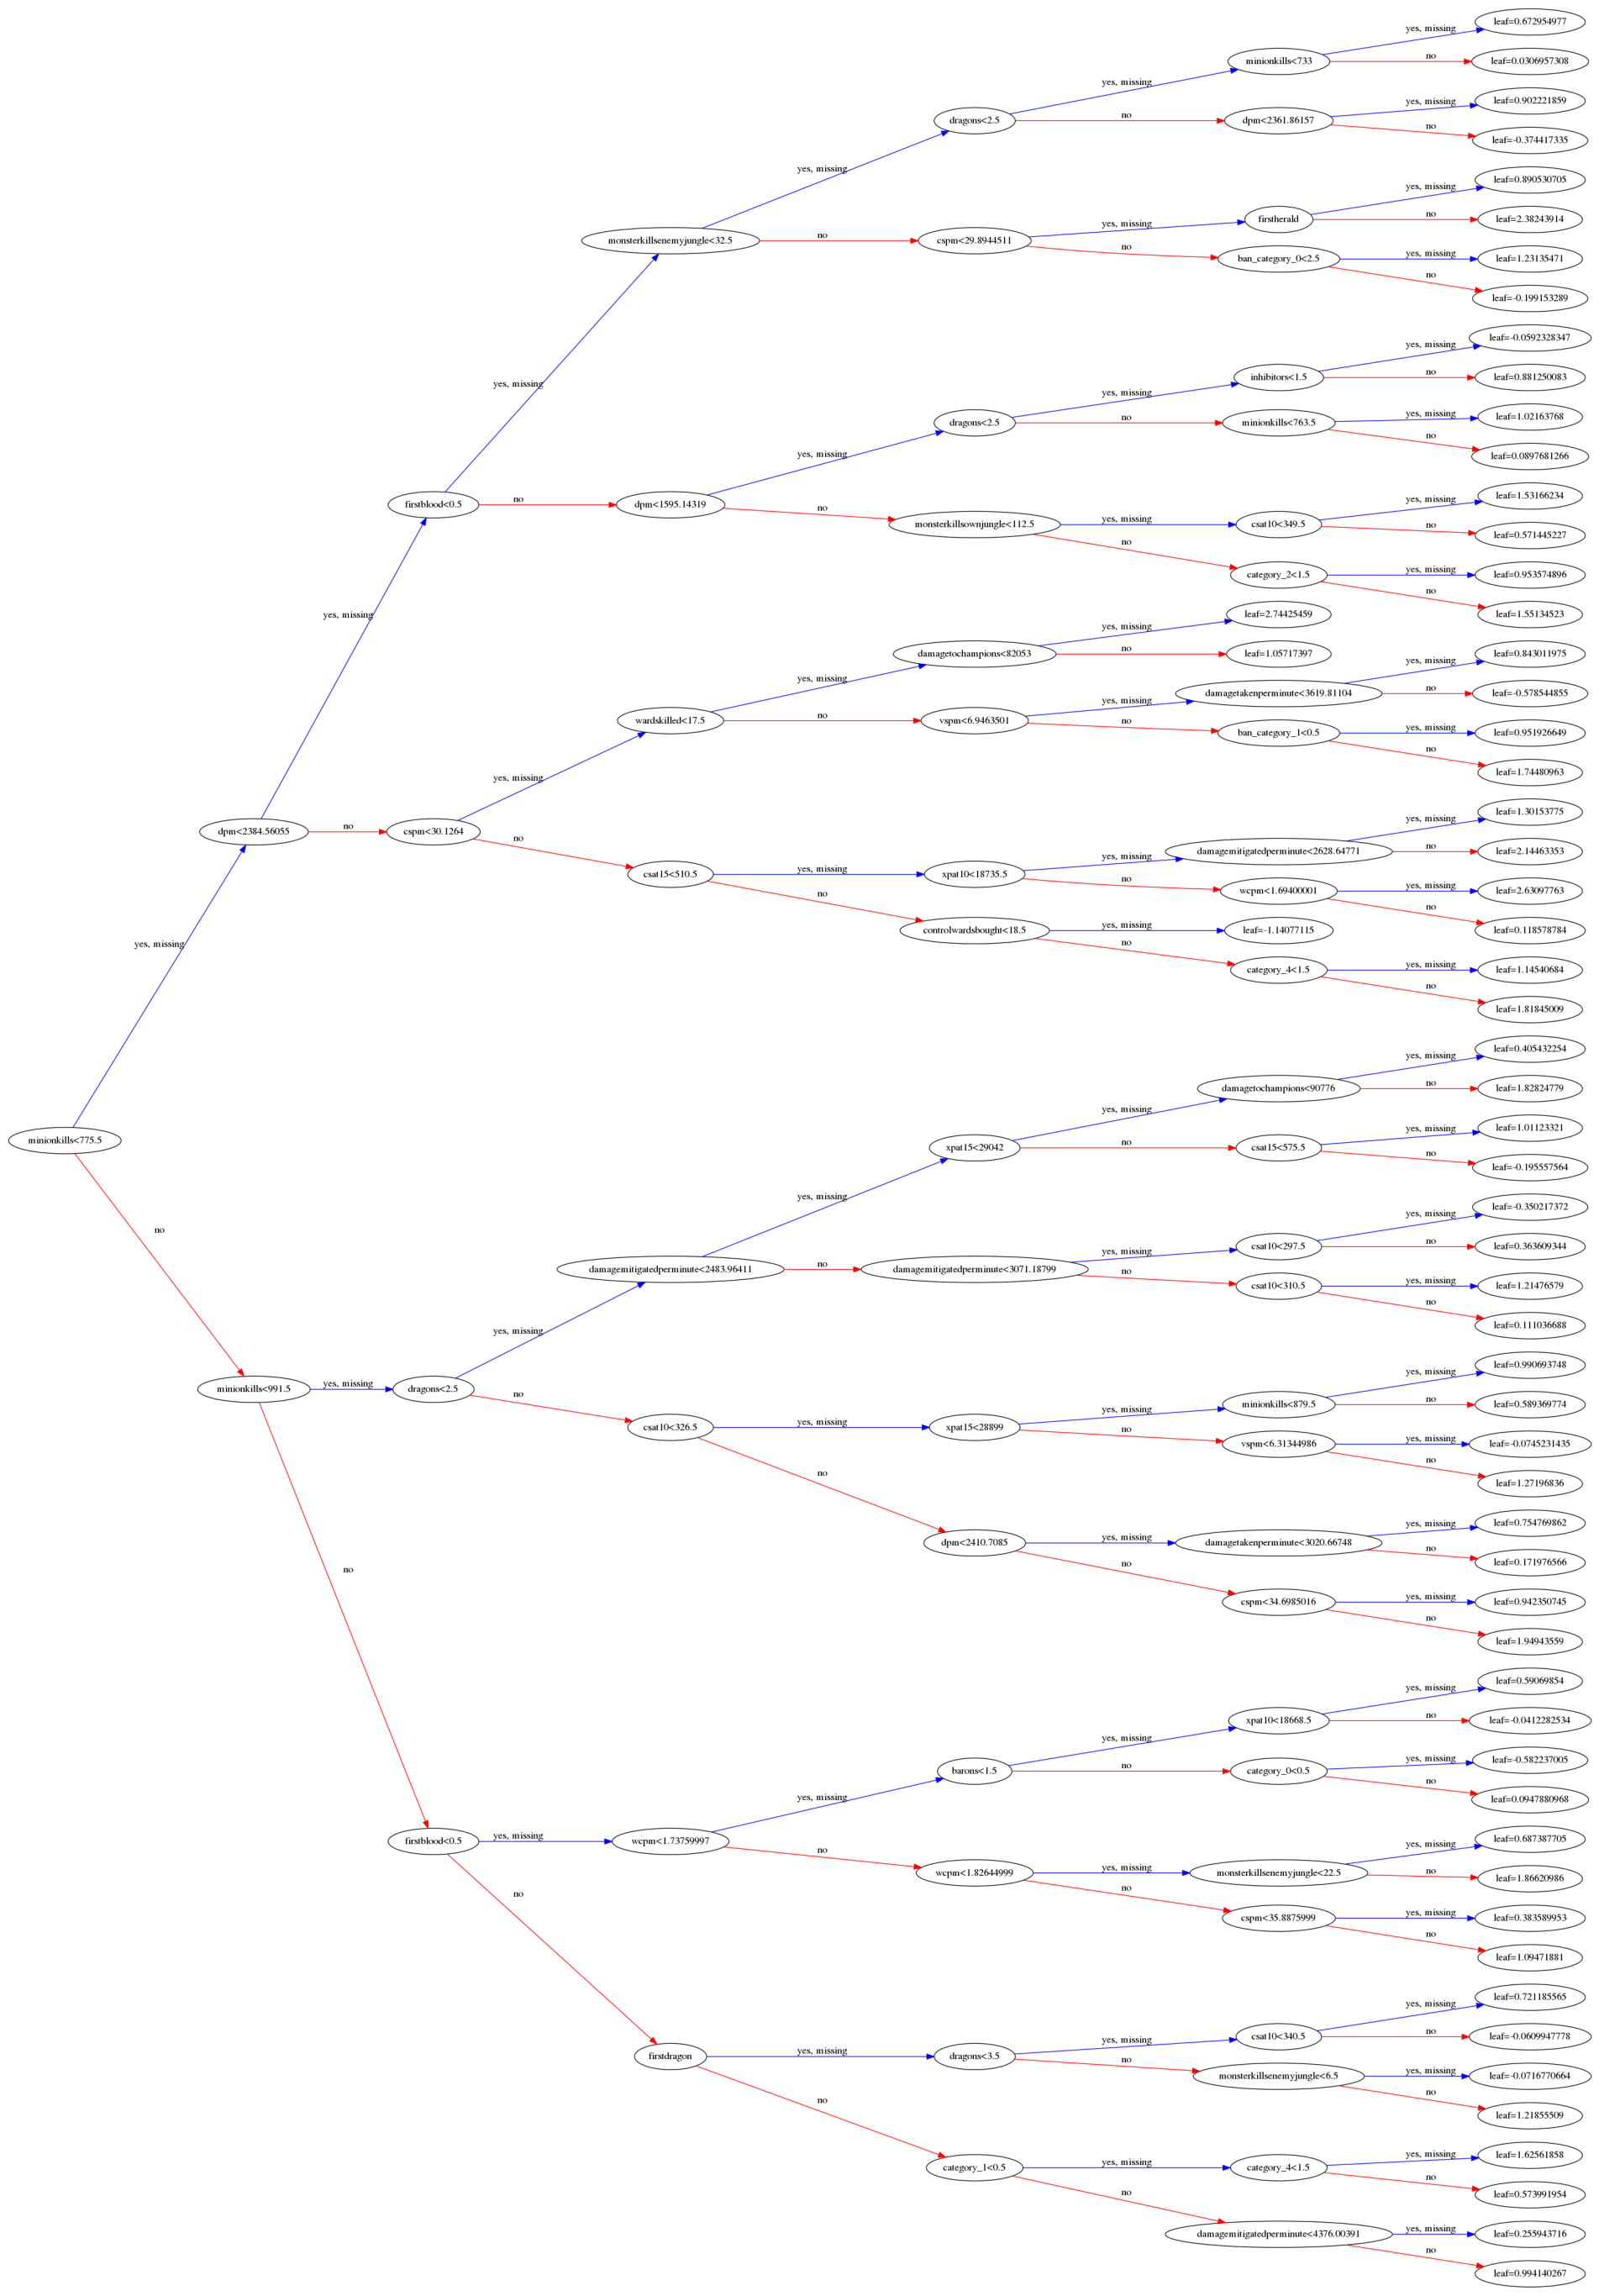

<Figure size 5760x3600 with 0 Axes>

In [65]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# fig, ax = plt.subplots(figsize=(30, 30))
plt.rcParams['figure.figsize'] = 80,50
xgb.plot_tree(win_fitted, num_trees=3, rankdir='LR')

plt.show()
plt.savefig('tree.png')

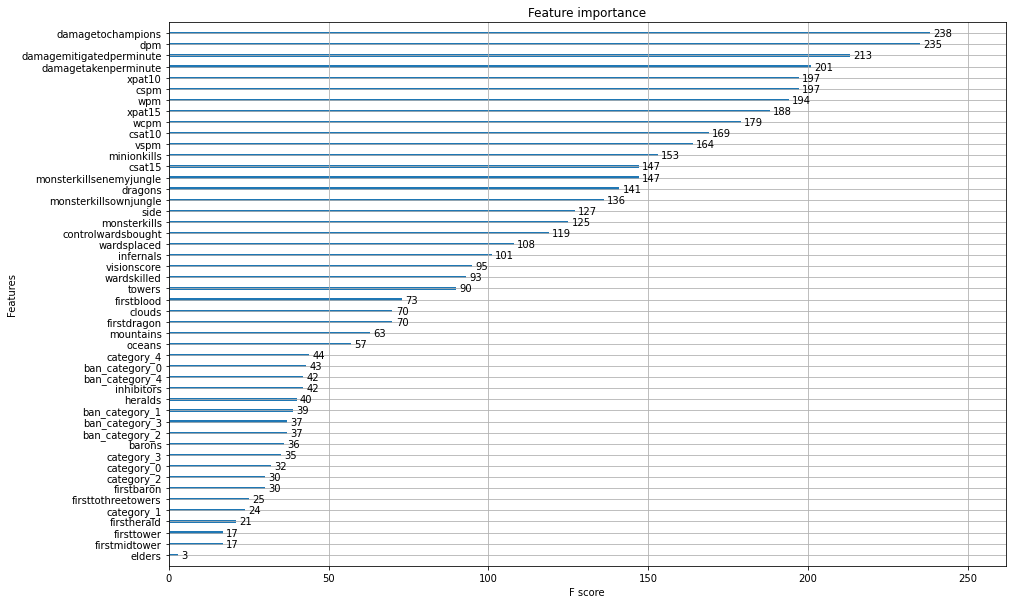

In [303]:
fig, ax = plt.subplots(figsize=(15, 10))

xgb.plot_importance(win_fitted, ax = ax)

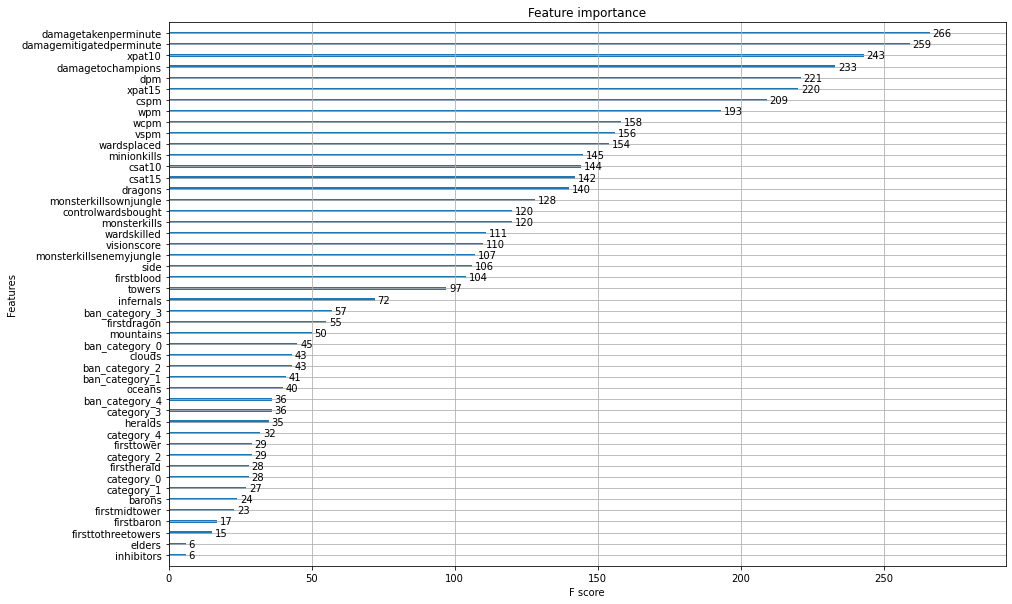

In [300]:
fig, ax = plt.subplots(figsize=(15, 10))


xgb.plot_importance(fail_fitted, ax = ax)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

In [29]:
score_train = gbc.score(x_train, y_train) # train set 정확도

print('{:.3f}'.format(score_train))

score_test = gbc.score(x_test, y_test) # 일반화 정확도

print('{:.3f}'.format(score_test))

0.993
0.975


### LightGBM

In [67]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=200)

In [69]:
evals = [(x_test, y_test)]
lgbm.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='MSE',
         eval_set=evals, verbose=False)

LGBMRegressor(n_estimators=200)

In [71]:
lgb_pred = lgbm.predict(x_test)

mean_squared_error(lgb_pred, y_test)

17.570562891675248

In [72]:
from catboost import CatBoostRegressor

In [76]:
model = CatBoostRegressor(iterations=50,
                           learning_rate=1,
                           depth=2, verbose=False)
# Fit model
model.fit(x_train, y_train)

preds_raw = model.predict(x_test)

In [77]:
mean_squared_error(preds_raw, y_test)

17.91193087712217

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

log_cl=LinearRegression()
rf_cl=RandomForestRegressor()
svm_cl=SVR()

voting_cl=VotingRegressor(estimators=[('lr', log_cl), ('rf', rf_cl), ('svc', svm_cl)])
voting_cl.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
for cl in (log_cl, rf_cl, svm_cl, voting_cl):
    cl.fit(x_train, y_train)
    y_pred = cl.predict(x_test)
    print(cl.__class__.__name__, mean_squared_error(y_test, y_pred))

LinearRegression 16.151646193222508
RandomForestRegressor 17.773217261219795
SVR 23.156531381399855
VotingRegressor 17.551598483760976
